# ADF for binary logistic regression

In [1]:
import os
import jax
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = ""
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from jax import random
import blackjax.rwmh as mh

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (5, 3)

In [5]:
def sigmoid(z): return jnp.exp(z) / (1 + jnp.exp(z))
def log_sigmoid(z): return z - jnp.log(1 + jnp.exp(z))

def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## The data

In [554]:
n_datapoints = 50
m = 2
X, rows, cols = make_biclusters((n_datapoints, m), 2, noise=0.6, random_state=314, minval=-3, maxval=3)
# whether datapoints belong to class 1
y = rows[0] * 1.0

Phi = jnp.c_[jnp.ones(n_datapoints)[:, None], X]
N, M = Phi.shape

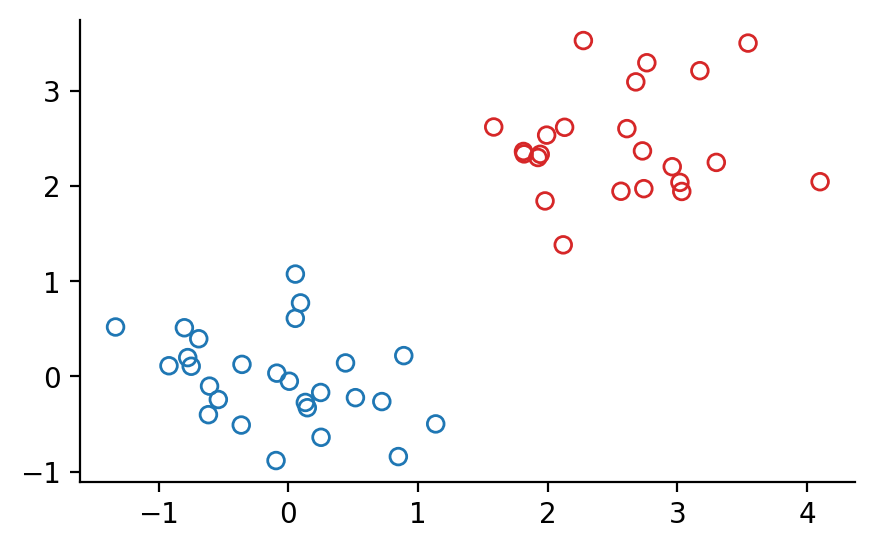

In [555]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.show()

## MCMC Sampling

In [556]:
key = random.PRNGKey(314)
init_noise = 1.0
w0 = random.multivariate_normal(key, jnp.zeros(M), jnp.eye(M) * init_noise)

In [557]:
alpha = 1.0

# Phi: array(N, M)
# w: array(M,)
# y: array(N,)
# (M=3)
def E(w):
    an = Phi @ w
    log_an = log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * jnp.log1p(-sigmoid(an))
    prior_term = alpha * w @ w / 2

    return prior_term - log_likelihood_term.sum()

In [558]:
sigma_mcmc = 0.8
initial_state = mh.new_state(w0, E)

mcmc_kernel = mh.kernel(E, jnp.ones(M) * sigma_mcmc)
mcmc_kernel = jax.jit(mcmc_kernel)

n_samples = 5_000
key_init = jax.random.PRNGKey(0)
states = inference_loop(key_init, mcmc_kernel, initial_state, n_samples)

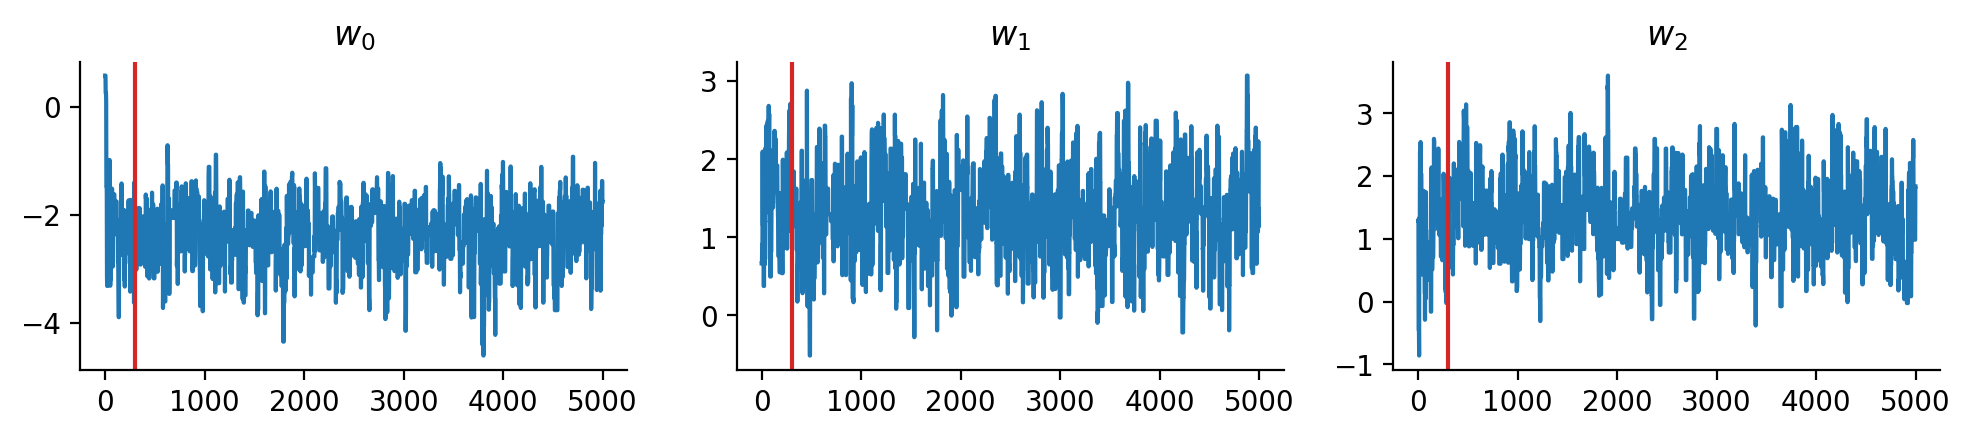

In [559]:
burnin = 300

fig, ax = plt.subplots(1, M, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

In [560]:
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

### Predictive distribution

In [561]:
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
Phispace.shape

(3, 57, 47)

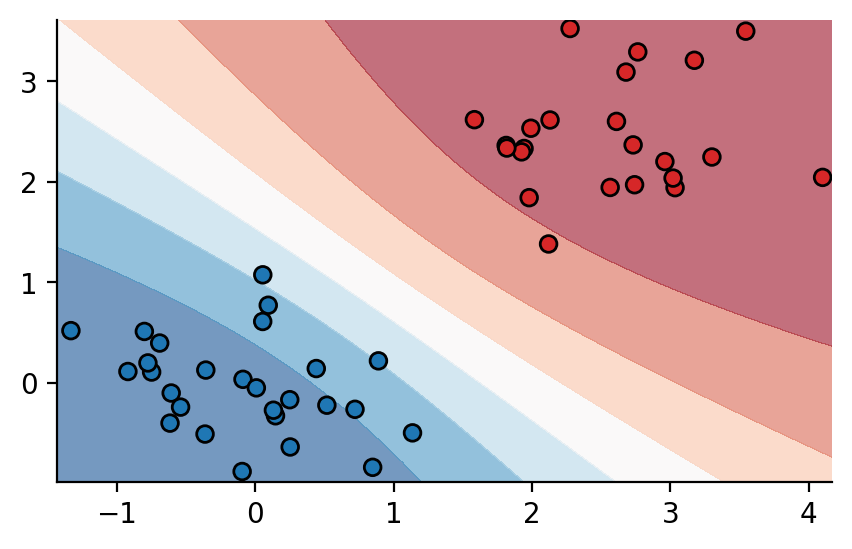

In [562]:
Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

plt.contourf(*Xspace, Z_mcmc, cmap="RdBu_r", alpha=0.6)
plt.scatter(*X.T, c=colors, edgecolors="black")
plt.show()

## The exact posterior

For the logistic regression, we have

$$
    p({\bf w} \vert \mathcal{D}) \propto \exp\big(-E({\bf w})\big),
$$

with 
$$
    E({\bf w}) = \frac{\alpha}{2} {\bf w}^T{\bf w} - \sum_{n=1}^N y_n \log(\sigma(a_n)) + (1 - y_n) + \log(1 - \sigma(a_n)),
$$

$a_n = {\bf w}^T{\bf x}_n$

In [563]:
import numpy as np
from probnum.quad import bayesquad

In [564]:
def sigmoid(z): return np.exp(z) / (1 + np.exp(z))
def log_sigmoid(z): return z - np.log(1 + np.exp(z))


# Phi: array(N, M)
# w: array(M,)
# y: array(N,)
def E_batch(w):
    # an = Phi @ w
    an = np.einsum("nm,sm->sn", Phi, w)
    log_an = log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * np.log(1 - sigmoid(an))
    prior_term = alpha * np.einsum("si,si->s", w, w) / 2

    return prior_term - log_likelihood_term.sum(axis=-1)

In [565]:
domain = np.array([-5, 5])

res, _ = bayesquad(lambda w: np.exp(-E_batch(w)), 3, domain=domain)
Zw = res.mean
Zw

0.0010709185926750112

In [566]:
res, _ = bayesquad(lambda w: w[:, 0] * np.exp(-E_batch(w)), 3, domain=domain, nevals=990)
res.mean 

<ipython-input-564-c23f6e43d26e>:12: RuntimeWarning: divide by zero encountered in log
  log_likelihood_term = y * log_an + (1 - y) * np.log(1 - sigmoid(an))
<ipython-input-564-c23f6e43d26e>:12: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_term = y * log_an + (1 - y) * np.log(1 - sigmoid(an))


nan

In [567]:
# mcmc weights-mean
chains.mean(axis=0)

DeviceArray([-2.3667,  1.3078,  1.3872], dtype=float64)

## Assumed Density Filtering (ADF)

In [568]:
import numpy as np
from scipy.integrate import quad
from probnum.quad import bayesquad

In [569]:
mu_t = jnp.zeros(M)
tau_t = jnp.ones(M) * init_noise

w_prior = w0.copy()

# one-step-ahead predictive density
mu_t_cond = mu_t.copy()
tau_t_cond = tau_t + jnp.ones(M) * alpha

# prior predictive distribution
m_t_cond = (Phi[0] * mu_t_cond).sum()
v_t_cond = (Phi[0] ** 2 * tau_t_cond).sum()

In [570]:
def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def mt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def vt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta ** 2 * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

## All together

In [571]:
def sigmoid(z): return np.exp(z) / (1 + np.exp(z))
def log_sigmoid(z): return z - np.log(1 + np.exp(z))

def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def mt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

def vt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * np.log(1 - sigmoid(eta))
    log_term = log_term - (eta -  mu) ** 2 / (2 * v ** 2)
    
    return eta ** 2 * np.exp(log_term) / np.sqrt(2 * np.pi * v ** 2)

In [572]:
q = 0.4
mu_t = w0.copy()
tau_t = jnp.ones(M) * q


lbound, ubound = -10, 10
for t in range(n_datapoints):
    # one-step-ahead predictive density
    mu_t_cond = mu_t.copy()
    tau_t_cond = tau_t.copy() + q

    # prior predictive distribution
    m_t_cond = (Phi[t] * mu_t_cond).sum()
    v_t_cond = (Phi[t] ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = np.sqrt(v_t_cond)

    Zt, _ = bayesquad(lambda eta: Zt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    Zt = Zt.mean

    mt, _ = bayesquad(lambda eta: mt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    mt = mt.mean / Zt

    vt, _ = bayesquad(lambda eta: vt_func(eta, y[t], m_t_cond, v_t_cond_sqrt),
                      1, domain=np.array([lbound, ubound]))
    vt = vt.mean / Zt - mt ** 2
    
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond

    a = Phi[t] * tau_t_cond / jnp.power(Phi[t] * tau_t_cond, 2).sum()
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a ** 2 * delta_v

In [573]:
# Adf weights-mean
mu_t

DeviceArray([-2.929 ,  0.9353,  1.5887], dtype=float64)

## Pure-jax version

In [574]:
# !pip install jax_cosmo
from jax_cosmo.scipy import integrate
from jax.scipy.stats import norm

In [584]:
def sigmoid(z): return jnp.exp(z) / (1 + jnp.exp(z))
def log_sigmoid(z): return z - jnp.log1p(jnp.exp(z))

def Zt_func(eta, y, mu, v):
    cst = jnp.log(2 * jnp.pi * v ** 2) / 2
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v) + cst
    
    return jnp.exp(log_term)

def mt_func(eta, y, mu, v, Zt):
    cst = jnp.log(2 * jnp.pi * v ** 2) / 2
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v) + cst
    
    return eta * jnp.exp(log_term) / Zt

def vt_func(eta, y, mu, v, Zt):
    cst = jnp.log(2 * jnp.pi * v ** 2) / 2
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v) + cst
    
    return eta ** 2 * jnp.exp(log_term) / Zt

def var_t_func(eta, y, mu, v, Zt, mean_t):
    cst = jnp.log(2 * jnp.pi * v ** 2) / 2
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v) + cst
    
    return (eta - mean_t) ** 2 * jnp.exp(log_term) / Zt

In [618]:
def adf_step(state, xs, *, q, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs
    
    mu_t_cond = mu_t
    tau_t_cond = tau_t + q

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    Zt = integrate.romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

    mt = integrate.romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    
    vt = integrate.romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    vt = vt - mt ** 2
    
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond

    a = Phi_t * tau_t_cond / (Phi_t ** 2 * tau_t_cond).sum()
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a ** 2 * delta_v
    
    return (mu_t, tau_t), (mu_t, tau_t)

In [643]:
from functools import partial

# prior variance
q = 0.0
lbound, ubound = -40.0, 35.0
mu_t = jnp.zeros(M)
tau_t = jnp.ones(M) * 3.0

init_state = (mu_t, tau_t)
xs = (Phi, y)

adf_loop = partial(adf_step, q=q, lbound=lbound, ubound=ubound)

In [644]:
%%time
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)
# Adf weights-mean
mu_t

CPU times: user 2.13 s, sys: 0 ns, total: 2.13 s
Wall time: 2.12 s


DeviceArray([-2.7995,  1.5351,  2.2149], dtype=float64)

In [645]:
# mcmc weights-mean
chains.mean(axis=0)

DeviceArray([-2.3667,  1.3078,  1.3872], dtype=float64)

In [646]:
key = random.PRNGKey(314)
adf_samples = random.multivariate_normal(key, mu_t, jnp.diag(tau_t), (5000,))

Z_adf = sigmoid(jnp.einsum("mij,sm->sij", Phispace, adf_samples))
Z_adf = Z_adf.mean(axis=0)

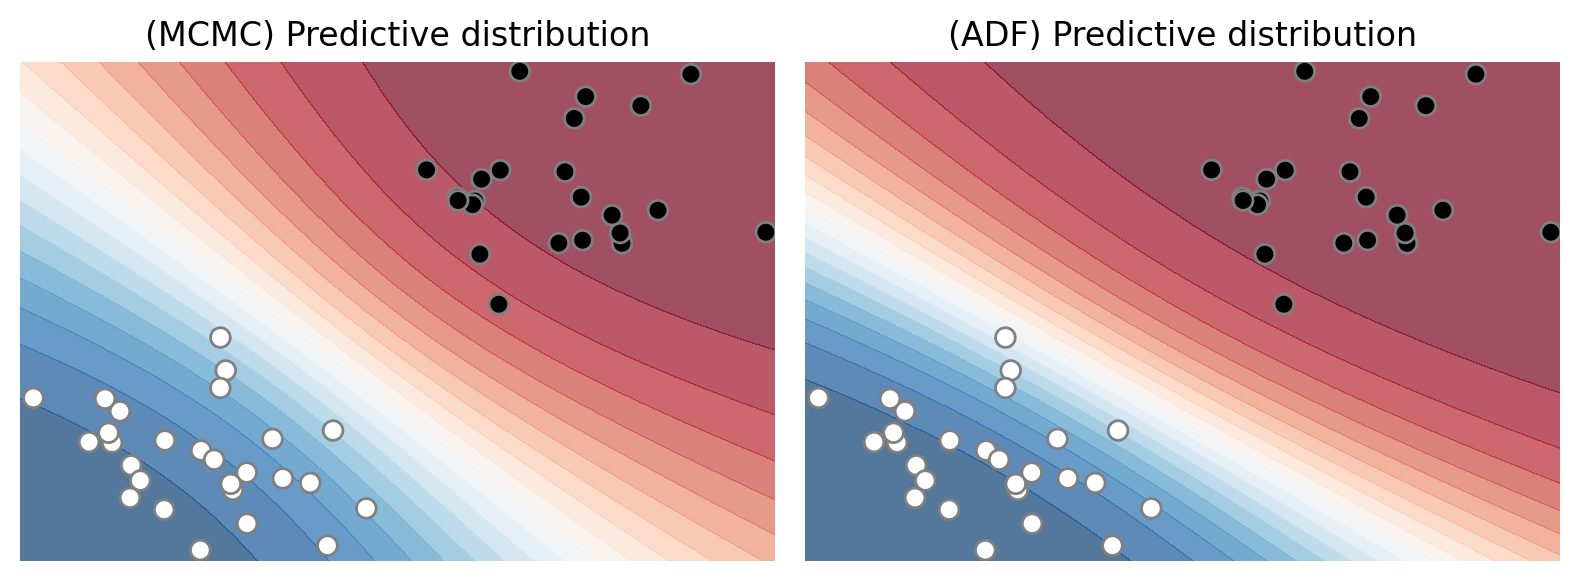

In [647]:
colors = ["black" if el else "white" for el in rows[0]]
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

levels = 20
colormap = "RdBu_r"
ax[0].contourf(*Xspace, Z_mcmc, cmap=colormap, alpha=0.7, levels=levels)
ax[0].scatter(*X.T, c=colors, edgecolors="gray", s=50)
ax[0].set_title("(MCMC) Predictive distribution")

ax[1].contourf(*Xspace, Z_adf, cmap=colormap, alpha=0.7, levels=levels)
ax[1].scatter(*X.T, c=colors, edgecolors="gray", s=50)
ax[1].set_title("(ADF) Predictive distribution")

ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()
plt.show()

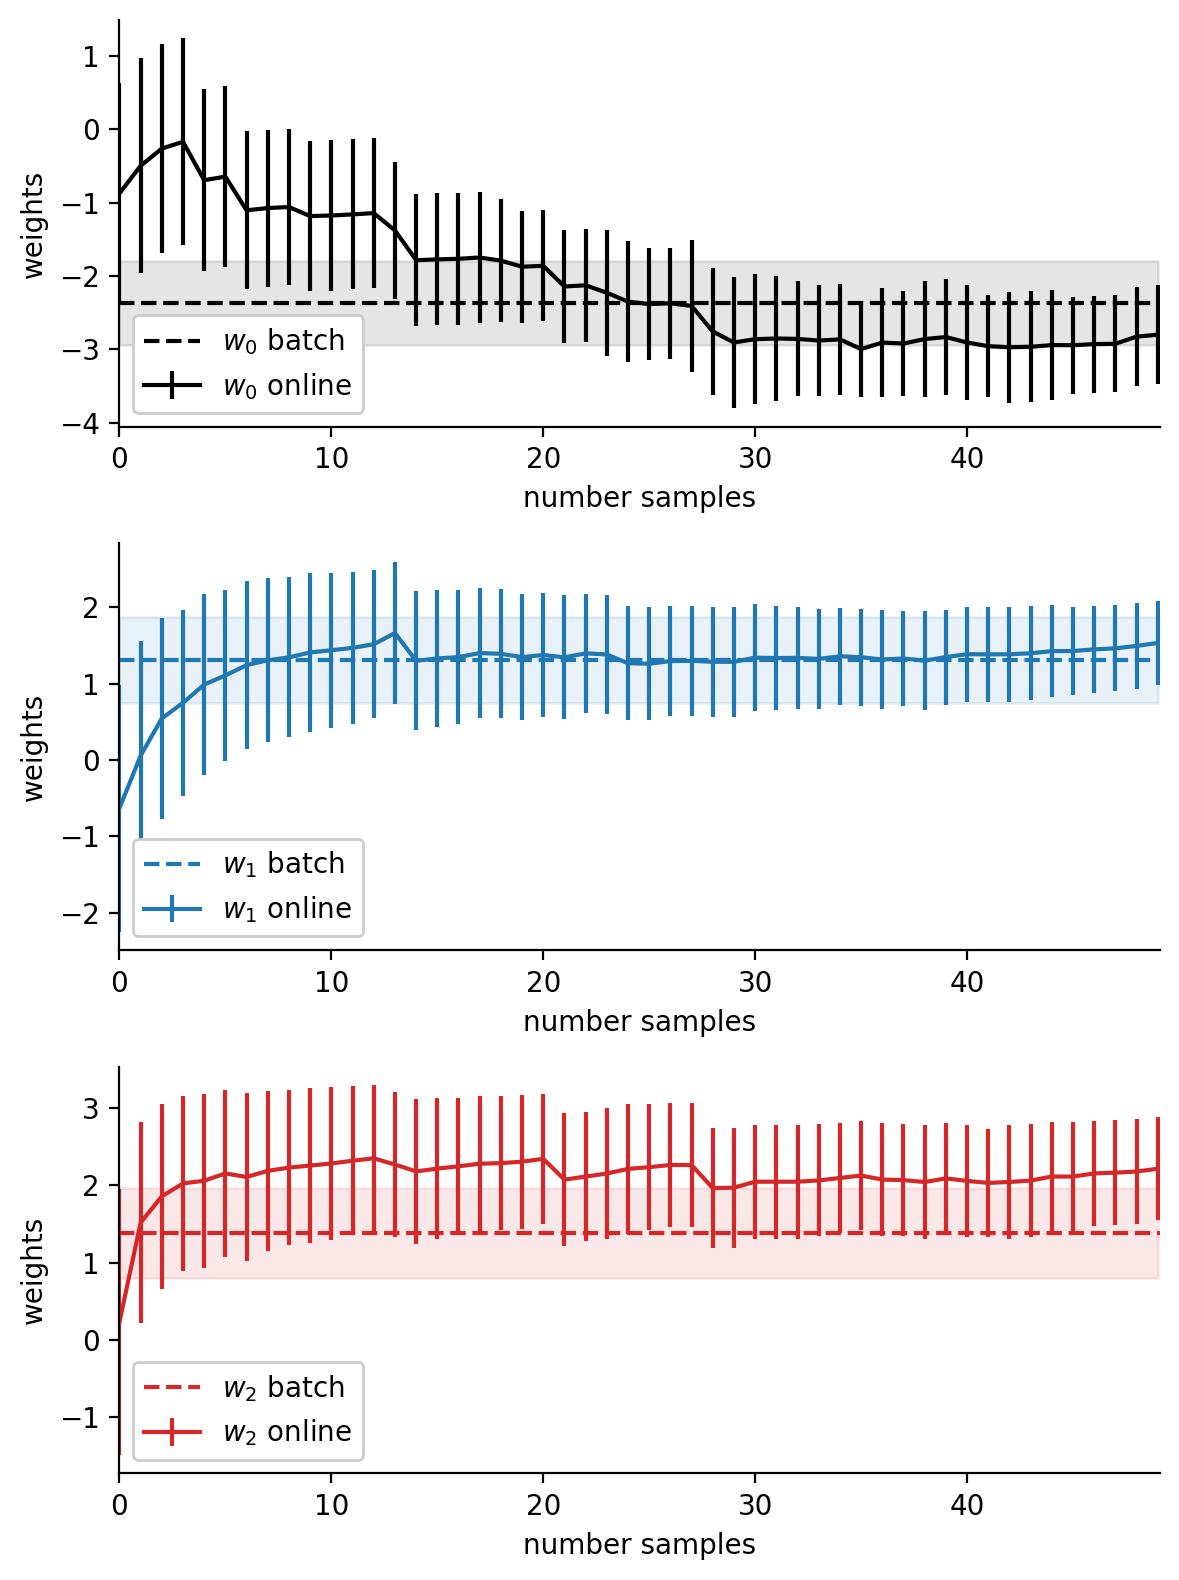

In [648]:
w_batch_all = chains.mean(axis=0)
w_batch_std_all = chains.std(axis=0)
timesteps = jnp.arange(n_datapoints)

lcolors = ["black", "tab:blue", "tab:red"]

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
elements = zip(mu_t_hist.T, tau_t_hist.T, w_batch_all, w_batch_std_all, lcolors)
for i, (w_online, w_err_online, w_batch, w_batch_err, c) in enumerate(elements):
    ax[i].errorbar(timesteps, w_online, jnp.sqrt(w_err_online), c=c, label=f"$w_{i}$ online")
    ax[i].axhline(y=w_batch, c=lcolors[i], linestyle="--", label=f"$w_{i}$ batch")
    ax[i].fill_between(timesteps, w_batch - w_batch_err, w_batch + w_batch_err, color=c, alpha=0.1)

    ax[i].legend(framealpha=1, loc="lower left")
    ax[i].set_xlim(0, n_datapoints - 0.9)
    ax[i].set_xlabel("number samples")
    ax[i].set_ylabel("weights")
plt.tight_layout()
plt.show()

## Laplace approximation

In [613]:
from jax.scipy.optimize import minimize
res = minimize(lambda x: E(x) / len(y), w0, method="BFGS")
w_map = res.x

In [614]:
SN = jax.hessian(E)(w_map)
SN

DeviceArray([[4.1899, 1.9512, 1.8255],
             [1.9512, 5.5362, 3.2377],
             [1.8255, 3.2377, 5.1993]], dtype=float64)

In [615]:
y_map = sigmoid(Phi @ w_map)
SN_exact = alpha * jnp.eye(M) + jnp.einsum("n,n,nm,nk->mk", y_map, 1 - y_map, Phi, Phi)
SN_exact

DeviceArray([[4.1899, 1.9512, 1.8255],
             [1.9512, 5.5362, 3.2377],
             [1.8255, 3.2377, 5.1993]], dtype=float64)

In [616]:
laplace_samples = random.multivariate_normal(key, w_map, SN, (5000,))

Z_laplace = sigmoid(jnp.einsum("mij,sm->sij", Phispace, laplace_samples))
Z_laplace = Z_laplace.mean(axis=0)

## Plot predictive distribution

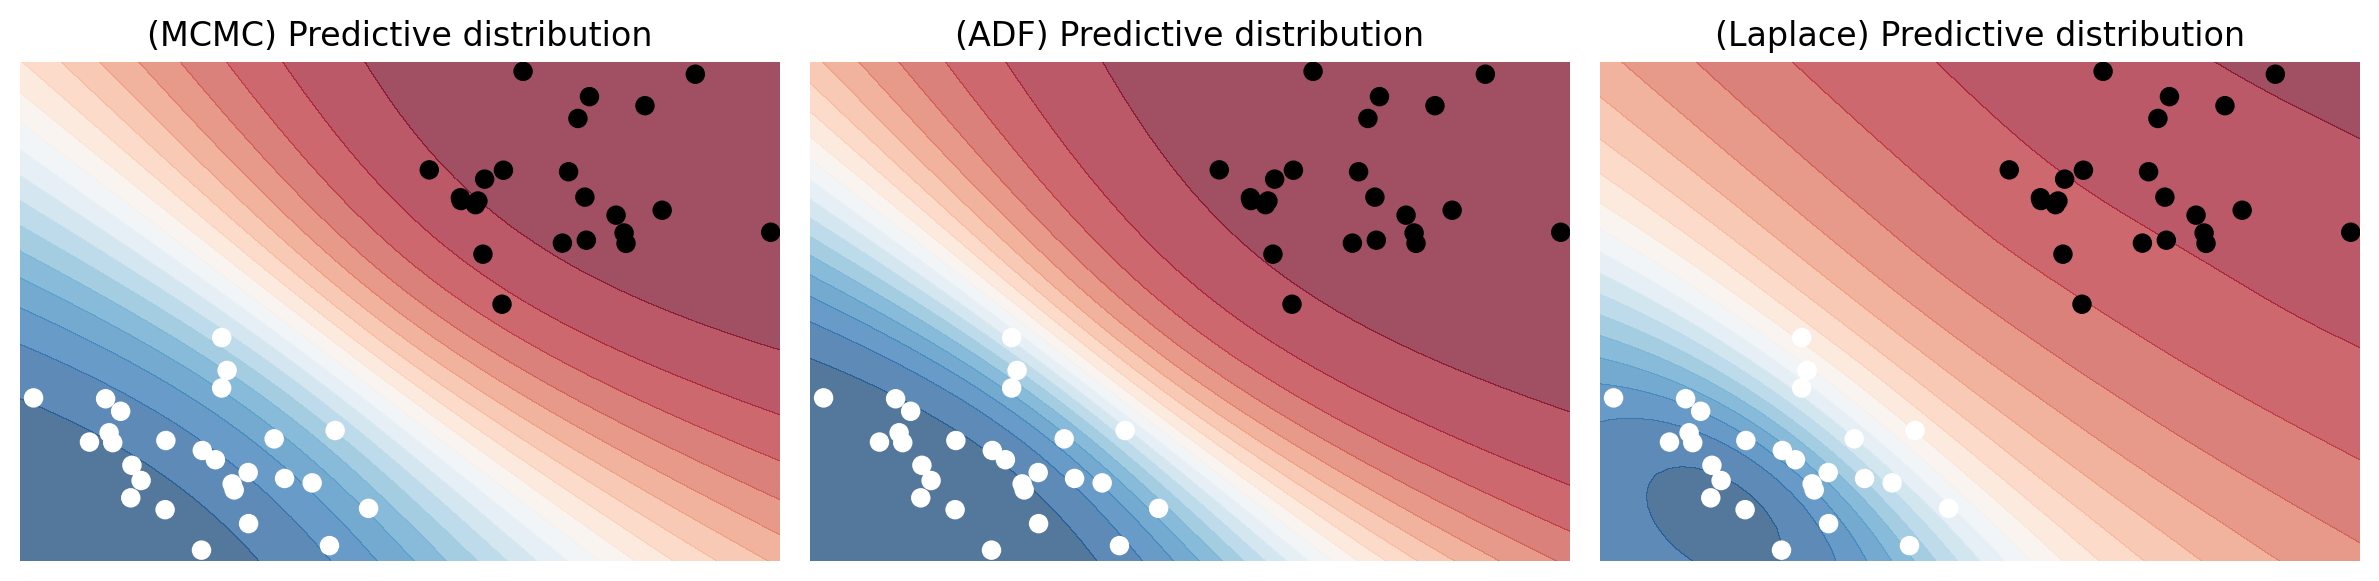

In [617]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].contourf(*Xspace, Z_mcmc, cmap="RdBu_r", alpha=0.7, levels=20)
ax[0].scatter(*X.T, c=colors)
ax[0].set_title("(MCMC) Predictive distribution")

ax[1].contourf(*Xspace, Z_adf, cmap="RdBu_r", alpha=0.7, levels=20)
ax[1].scatter(*X.T, c=colors)
ax[1].set_title("(ADF) Predictive distribution")

ax[2].contourf(*Xspace, Z_laplace, cmap="RdBu_r", alpha=0.7, levels=20)
ax[2].scatter(*X.T, c=colors)
ax[2].set_title("(Laplace) Predictive distribution")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.tight_layout()
plt.show()